In [1]:
%pip install hazm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/P3 files (2)


/content/drive/MyDrive/P3 files (2)


In [25]:
import pandas as pd
import numpy as np
from hazm import Normalizer, WordTokenizer, Lemmatizer, WordEmbedding
import string
import re
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [5]:
df = pd.read_csv("emails.csv")

In [6]:
df

,text,label
0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham
1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham
2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham
3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham
4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham
...,...,...
995,﻿\nبسمه تعالی\n\nسازمان زیباسازی شهرداری استان...,spam
996,﻿\n\nبه مناسبت فرا رسیدن میلاد دخت پیامبر گرام...,spam
997,﻿\nدرود هموطن من\n\n \n\nتست رایگان \n\n ...,spam
998,﻿\n\n *درج **لینک در 8700 وبلاگ\n *\n\n...,spam


In [7]:
category_counts = df['label'].value_counts()
category_counts

label
ham     500
spam    500
Name: count, dtype: int64

### a fully balanced dataset wow!

## Changing spam and ham to 1 and 0

In [8]:
df['label']=df['label'].apply(lambda x:1 if x=='spam' else 0)

## Data preprocessing

### Removing '\n's

In [9]:
# Remove the "\n" characters from the text column
df['text'] = df['text'].str.replace('\n', ' ')


In [10]:
# Function to remove English words and characters
def remove_english(text):
    # Regex to remove words with English letters and standalone English letters
    cleaned_text = re.sub(r'\b[a-zA-Z]+\b', '', text)  # Removes words composed only of English letters
    cleaned_text = re.sub(r'[a-zA-Z]', '', cleaned_text)  # Removes standalone English letters
    return cleaned_text
df['text'] = df['text'].apply(remove_english)

### Removing punctuation

In [11]:
# Function to remove punctuation from text
def remove_punctuation(text):
    # Define a translation table with all punctuation characters mapped to None
    translator = str.maketrans(' ', ' ', string.punctuation)
    # Remove punctuation using the translation table
    return text.translate(translator)

# Apply the function to the "Content" column
df['text'] = df['text'].apply(remove_punctuation)


### Removing numbers

In [12]:
# Function to remove numbers from text using regular expressions
def remove_numbers(text):
    # Use regular expression to remove all numbers
    return re.sub(r'\d+', '', text)

df['text'] = df['text'].apply(remove_numbers)

In [13]:
normalizer = Normalizer()
df['text'] = df['text'].apply(lambda text: normalizer.normalize(text))

In [14]:
tokenizer = WordTokenizer()
df['Tokenized_Content'] = df['text'].apply(lambda text: tokenizer.tokenize(text))

In [15]:
# Read stop words from the text file
with open("PersianStopWords.txt", "r", encoding="utf-8") as file:
    stop_words = set(file.read().splitlines())

# Define a function to remove stop words
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply the function to the "Tokenized_Content" column
df['Tokenized_Content'] = df['Tokenized_Content'].apply(remove_stop_words)

In [16]:
df

,text,label,Tokenized_Content
0,﻿ممنون آقا سامان من پارسال اصلا آزاد شرکت نکرد...,0,"[﻿ممنون, آقا, سامان, آزاد, شرکت, نکرده_بودم, س..."
1,﻿سلام آقای کریمی بالاخره آزمونارشد تموم شد من ...,0,"[﻿سلام, آقای, کریمی, آزمونارشد, تموم, شدم, یکم..."
2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,0,"[﻿درود, حاج, وحیدی, بنده, بعنوان, یک, دکتری, ت..."
3,﻿با سلام و احترام ضمن تقدیر از مسولین محترم سا...,0,"[﻿با, سلام, احترام, ضمن, تقدیر, مسولین, محترم,..."
4,﻿با سلام اینجانب یک دستگاه خودرو پراید با شمار...,0,"[﻿با, سلام, اینجانب, یک, دستگاه, خودرو, پراید,..."
...,...,...,...
995,﻿ بسمه تعالی سازمان زیباسازی شهرداری استان تهر...,1,"[﻿, بسمه, تعالی, سازمان, زیباسازی, شهرداری, اس..."
996,﻿ به مناسبت فرا رسیدن میلاد دخت پیامبر گرامی ا...,1,"[﻿, مناسبت, فرا, رسیدن, میلاد, دخت, پیامبر, گر..."
997,﻿ درود هموطن من تست رایگان تحویل اکانت پرداخت ...,1,"[﻿, درود, هموطن, تست, رایگان, تحویل, اکانت, پر..."
998,﻿ درج لینک در وبلاگ درج لینک و تبلیغات متنی شم...,1,"[﻿, درج, لینک, وبلاگ, درج, لینک, تبلیغات, متنی..."


In [17]:
df['text'] = df['Tokenized_Content'].apply(lambda tokens: ' '.join(tokens))

## Using TF-IDF

In [18]:
# Create a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the 'text' column of the DataFrame
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Convert to DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [19]:
tfidf_df

,آئید,آئین,آاگر,آب,آبا,آباد,آبادانی,آبادی,آبان,آبانماه,...,یکیشونه,یکیه,یگ,یگان,یگانه,یگر,یی,ییخیال,ییخیلی,ییلاق
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Now we are good to go for training KNN

In [20]:
X = tfidf_df.copy()
y = df['label']

In [22]:
# Split the data into training and testing sets (80-20 split used here)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42 , shuffle=True)

In [23]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data only
X_train = scaler.fit_transform(X_train)

# Apply the same scaler to transform the test data
X_test = scaler.transform(X_test)

In [26]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [27]:
# Define the model and parameters
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 21)}

In [28]:
# Setup the grid search with cross-validation
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

In [29]:
# Perform the grid search
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='accuracy')

In [30]:
# Best model
best_k = grid.best_params_['n_neighbors']
best_score = grid.best_score_

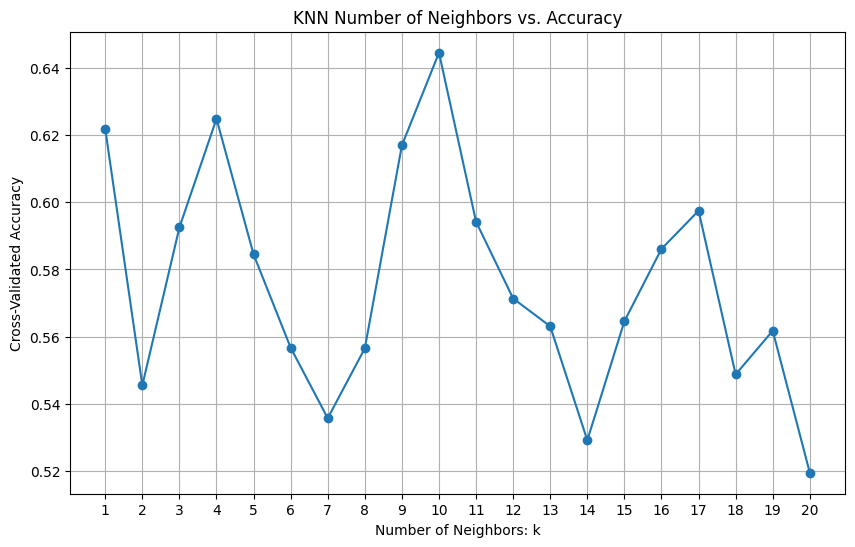

Best k: 10
Best cross-validated accuracy: 0.6444794125360608


In [31]:
# Results for plotting
mean_scores = grid.cv_results_['mean_test_score']
k_values = np.arange(1, 21)

# Plotting accuracy vs K
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, marker='o')
plt.xlabel('Number of Neighbors: k')
plt.ylabel('Cross-Validated Accuracy')
plt.title('KNN Number of Neighbors vs. Accuracy')
plt.grid(True)
plt.xticks(k_values)
plt.show()

print("Best k:", best_k)
print("Best cross-validated accuracy:", best_score)